In [3]:
from generator import Generator
from critic import Critic
from dog_dataset import DogData

In [4]:
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
from torch import optim

In [5]:
device = torch.device("cuda:0")
torch.cuda.set_device(0)

In [6]:
batchSize = 10

In [7]:
transform = transforms.Compose( [ transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) ] )
dogdata = DogData(transform)
dogloader = DataLoader(dogdata, shuffle=True, batch_size=batchSize, num_workers=3)

In [8]:
def get_critic_scores(real_batch, batchSize, critic, generator):
    generator.batchSize = batchSize
    critic.batchSize = batchSize
    #generate fake images
    randoBatch = torch.randn([batchSize, 100, 1, 1])
    randoBatch = randoBatch.to(device)
    generated = generator(randoBatch)
    #compute scores of both real and fake using the critic
    batch = real_batch[0]
    batch = batch.to(device)
    real_scores = critic(batch)
    gen_scores = critic(generated)
    return ( torch.sum(real_scores) , torch.sum(gen_scores) )

In [9]:
def get_generator_score(batchSize, critic, generator):
    generator.batchSize = batchSize
    #generate fake images
    randoBatch = torch.randn([batchSize, 100, 1, 1])
    randoBatch = randoBatch.to(device)
    generated = generator(randoBatch)
    #compute scores of generated using critic
    gen_scores = critic(generated)
    return torch.sum(gen_scores)

In [10]:
class WeightClipper(object):

    def __init__(self, frequency=5):
        self.frequency = frequency

    def __call__(self, module):
        # filter the variables to get the ones you want
        if hasattr(module, 'weight'):
            w = module.weight.data
            w = w.clamp(-0.01,0.01)
            module.weight.data = w

In [11]:
critic = Critic()
generator = Generator()
clipper = WeightClipper()
generator.to(device)
critic.to(device)
critic.apply(clipper)

Critic(
  (convBlocks): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
    )
  )
  (fcBlocks): Sequential(
    (0): Sequential(
      (0): Linear(in_features=112896, out_features=100, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=50, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (2): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [12]:
num_epochs = 500
critic_epochs = 4
gen_epochs = 1

In [13]:
criticOptim = optim.RMSprop(critic.parameters(), lr=0.0005)#, momentum=0.5)
genOptim = optim.RMSprop(generator.parameters(), lr=0.0005)#, momentum=0.5)

In [14]:
import matplotlib.pyplot as plt

Entering epoch yay: 0
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
769.4337483644485
362.2357393503189
-407.19800901412964
Generator batch: 0
-3080.6904296875
Entering epoch yay: 1
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
14103.277923583984
32485.676391601562
18382.397491455078
Generator batch: 0
-317.11883544921875
Entering epoch yay: 2
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
-2403.0865173339844
-4408.705383300781
-2005.6188659667969
Generator batch: 0
9672.3125
Entering epoch yay: 3
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
-28844.827880859375
-51085.58154296875
-22240.753662109375
Generator batch: 0
98950.171875
Entering epoch yay: 4
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
-78669.130859375
-99023.244140625
-20354.11328125
Generator batch: 0
61253.140625
Entering epoch yay: 5
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
664171.5087890625
-1539375.4453125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


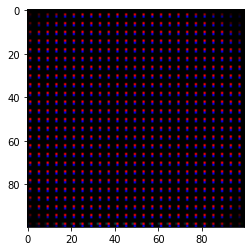

Entering epoch yay: 20
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
65113597952.0
54639011840.0
-10474586112.0
Generator batch: 0
-13115918336.0
Entering epoch yay: 21
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
66818629632.0
50600016896.0
-16218612736.0
Generator batch: 0
-11246798848.0
Entering epoch yay: 22
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
81724342272.0
46342157312.0
-35382184960.0
Generator batch: 0
-11634604032.0
Entering epoch yay: 23
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
143894978560.0
48326443008.0
-95568535552.0
Generator batch: 0
-12518691840.0
Entering epoch yay: 24
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
193708666880.0
51909397504.0
-141799268352.0
Generator batch: 0
-12970859520.0
Entering epoch yay: 25
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
389961818112.0
64190667776.0
-325771149312.0
Generator batch: 0
-14237841408.0
Entering ep

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
794723762176.0
2996831387648.0
2202107609088.0
Generator batch: 0
-684553142272.0


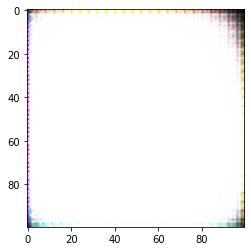

Entering epoch yay: 40
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
689393762304.0
2663029800960.0
1973636038656.0
Generator batch: 0
-614253199360.0
Entering epoch yay: 41
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
627768778752.0
2374049398784.0
1746280644608.0
Generator batch: 0
-559969665024.0
Entering epoch yay: 42
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
577031536640.0
2137743032320.0
1560711528448.0
Generator batch: 0
-502138503168.0
Entering epoch yay: 43
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
547545849856.0
1939688390656.0
1392142548992.0
Generator batch: 0
-452396187648.0
Entering epoch yay: 44
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
508783796224.0
1771381227520.0
1262597439488.0
Generator batch: 0
-421411323904.0
Entering epoch yay: 45
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
495081644032.0
1622408495104.0
1127326875648.0
Generator batch: 0
-3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


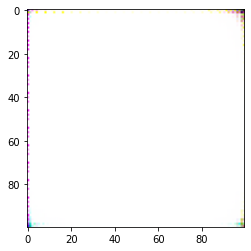

Entering epoch yay: 60
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
393039994880.0
678228688896.0
285188694016.0
Generator batch: 0
-164640161792.0
Entering epoch yay: 61
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
389817303040.0
643957620736.0
254140317696.0
Generator batch: 0
-158378573824.0
Entering epoch yay: 62
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
390580740096.0
619991171072.0
229410430976.0
Generator batch: 0
-151595352064.0
Entering epoch yay: 63
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
405000552448.0
596886716416.0
191886163968.0
Generator batch: 0
-145445715968.0
Entering epoch yay: 64
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
395466235904.0
571206942720.0
175740706816.0
Generator batch: 0
-138930290688.0
Entering epoch yay: 65
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
380629999616.0
548633427968.0
168003428352.0
Generator batch: 0
-133601845248.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


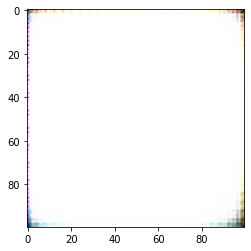

Entering epoch yay: 80
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
634809368576.0
308185522176.0
-326623846400.0
Generator batch: 0
-75191091200.0
Entering epoch yay: 81
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
689966776320.0
300663939072.0
-389302837248.0
Generator batch: 0
-74197467136.0
Entering epoch yay: 82
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
733827825664.0
294154027008.0
-439673798656.0
Generator batch: 0
-72914419712.0
Entering epoch yay: 83
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
846331691008.0
290044592128.0
-556287098880.0
Generator batch: 0
-71607140352.0
Entering epoch yay: 84
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
931447193600.0
285208616960.0
-646238568448.0
Generator batch: 0
-70931234816.0
Entering epoch yay: 85
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
1079486529536.0
282717495296.0
-796769042432.0
Generator batch: 0
-70360473600

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


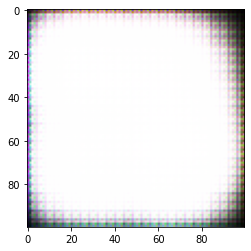

Entering epoch yay: 100
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
19480387780608.0
497518010368.0
-18982869401600.0
Generator batch: 0
-131159072768.0
Entering epoch yay: 101
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
21291410653184.0
530804867072.0
-20760605753344.0
Generator batch: 0
-131694321664.0
Entering epoch yay: 102
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
28998909820928.0
545251811328.0
-28453657640960.0
Generator batch: 0
-132881874944.0
Entering epoch yay: 103
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
37877334933504.0
538218086400.0
-37339117649920.0
Generator batch: 0
-149586083840.0
Entering epoch yay: 104
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
44567141285888.0
542895718400.0
-44024246304768.0
Generator batch: 0
-130907914240.0
Entering epoch yay: 105
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
54700846088192.0
510116724736.0
-54190729592832

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
539362446016512.0
497998503936.0
-538864447913984.0
Generator batch: 0
-18053224448.0


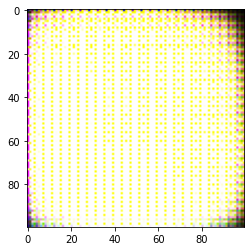

Entering epoch yay: 120
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
633928465514496.0
838620519040.0
-633089847984128.0
Generator batch: 0
-224945225728.0
Entering epoch yay: 121
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
577007448489984.0
771403791360.0
-576236040486912.0
Generator batch: 0
-177803706368.0
Entering epoch yay: 122
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
655897961431040.0
1648429326336.0
-654249549627392.0
Generator batch: 0
-282628030464.0
Entering epoch yay: 123
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
757001927786496.0
18701436321792.0
-738300482551808.0
Generator batch: 0
-3142713868288.0
Entering epoch yay: 124
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
933545669296128.0
657784139939840.0
-275761529356288.0
Generator batch: 0
-161050519404544.0
Entering epoch yay: 125
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
914720122994688.0
126104732

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-232602996834304.0


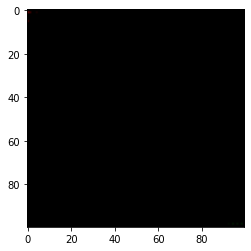

Entering epoch yay: 140
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
273727430328320.0
912175975628800.0
638448566272000.0
Generator batch: 0
-220703487950848.0
Entering epoch yay: 141
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
224771589537792.0
849643063738368.0
624871486783488.0
Generator batch: 0
-209598531239936.0
Entering epoch yay: 142
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
243113352232960.0
822662817382400.0
579549465149440.0
Generator batch: 0
-196854289530880.0
Entering epoch yay: 143
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
233805239549952.0
785312120832000.0
551506877087744.0
Generator batch: 0
-187388248719360.0
Entering epoch yay: 144
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
227044382212096.0
749343615221760.0
522299237203968.0
Generator batch: 0
-180758698262528.0
Entering epoch yay: 145
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
218503235764

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
124936504999936.0
409867235885056.0
284930726690816.0
Generator batch: 0
-101256177647616.0


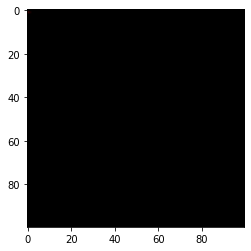

Entering epoch yay: 160
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
116286348591104.0
399590662602752.0
283304314011648.0
Generator batch: 0
-97199841083392.0
Entering epoch yay: 161
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
117849253216256.0
382363641053184.0
264514389934080.0
Generator batch: 0
-94466882928640.0
Entering epoch yay: 162
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
121193464070144.0
371841172504576.0
250647710531584.0
Generator batch: 0
-91485580034048.0
Entering epoch yay: 163
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
114504895561728.0
361291852021760.0
246786954362880.0
Generator batch: 0
-88432655204352.0
Entering epoch yay: 164
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
92781171179520.0
348651083792384.0
255869912612864.0
Generator batch: 0
-85468607676416.0
Entering epoch yay: 165
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
105012892008448.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
59956464189440.0
217507671572480.0
157551211577344.0
Generator batch: 0
-53319988936704.0


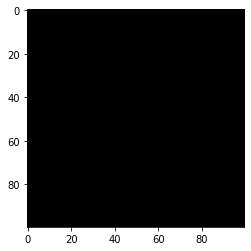

Entering epoch yay: 180
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
61276149514240.0
210966742564864.0
149690595147776.0
Generator batch: 0
-51737637421056.0
Entering epoch yay: 181
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
64803138699264.0
204709461753856.0
139906324103168.0
Generator batch: 0
-50180527226880.0
Entering epoch yay: 182
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
63701221638144.0
198707274317824.0
135006051631104.0
Generator batch: 0
-48717805649920.0
Entering epoch yay: 183
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
57876979646464.0
192886830268416.0
135009851670528.0
Generator batch: 0
-47387372421120.0
Entering epoch yay: 184
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
61687085400064.0
187419630501888.0
125732544053248.0
Generator batch: 0
-46051453042688.0
Entering epoch yay: 185
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
63215135358976.0
18217

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


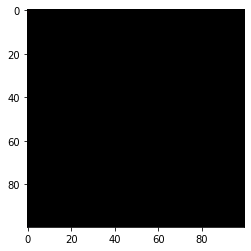

Entering epoch yay: 200
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
39858574721024.0
119958350594048.0
80099774824448.0
Generator batch: 0
-29499544567808.0
Entering epoch yay: 201
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
37951527976960.0
116760592252928.0
78809063751680.0
Generator batch: 0
-28705384562688.0
Entering epoch yay: 202
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
36673786216448.0
113432802099200.0
76759017979904.0
Generator batch: 0
-27927492165632.0
Entering epoch yay: 203
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
33763779149824.0
110522882064384.0
76759103963136.0
Generator batch: 0
-27124201160704.0
Entering epoch yay: 204
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
34410549215232.0
107384693325824.0
72974143062016.0
Generator batch: 0
-26378313400320.0
Entering epoch yay: 205
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
32836787634176.0
1036928124

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
25834562781184.0
71946012196864.0
46111449415680.0
Generator batch: 0
-17693564469248.0


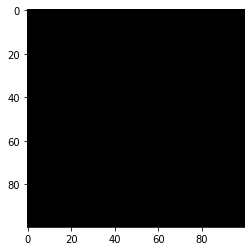

Entering epoch yay: 220
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
25708905103360.0
69900595888128.0
44191691309056.0
Generator batch: 0
-17155076653056.0
Entering epoch yay: 221
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
24660874887168.0
68289309966336.0
43628435079168.0
Generator batch: 0
-16786946785280.0
Entering epoch yay: 222
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
25908185399296.0
66567533494272.0
40659348094976.0
Generator batch: 0
-16381443571712.0
Entering epoch yay: 223
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
25179341717504.0
64670073356288.0
39490732163072.0
Generator batch: 0
-15986350620672.0
Entering epoch yay: 224
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
22243533914112.0
63055337619456.0
40811803705344.0
Generator batch: 0
-15541028782080.0
Entering epoch yay: 225
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
23944231387136.0
61667698278400.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
16073506947072.0
42800927211520.0
26727420002304.0
Generator batch: 0
-10543844818944.0


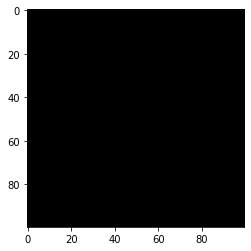

Entering epoch yay: 240
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
16531026608128.0
41777436295168.0
25246409687040.0
Generator batch: 0
-10267185381376.0
Entering epoch yay: 241
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
15460186980352.0
40696194007040.0
25236007288832.0
Generator batch: 0
-9973632335872.0
Entering epoch yay: 242
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
15843130867712.0
39655104839680.0
23811974496256.0
Generator batch: 0
-9760625655808.0
Entering epoch yay: 243


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f0eb17c8080>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
KeyboardInterrupt: 


Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
15602201919488.0
38662051987456.0
23059849805824.0
Generator batch: 0
-9481178054656.0
Entering epoch yay: 244
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
15389599989760.0
37690011549696.0
22300411297792.0
Generator batch: 0
-9204046757888.0
Entering epoch yay: 245
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
15044934107136.0
36748944998400.0
21704011153408.0
Generator batch: 0
-9046534914048.0
Entering epoch yay: 246
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
14402183757824.0
35808240205824.0
21406056185856.0
Generator batch: 0
-8810028597248.0
Entering epoch yay: 247
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
14537308766208.0
34913177829376.0
20375869063168.0
Generator batch: 0
-8595175899136.0
Entering epoch yay: 248
Critic batch: 0
Critic batch: 1
Critic batch: 2
Critic batch: 3
13853041885184.0
33923473080320.0
20070430932992.0
Generator 

KeyboardInterrupt: ignored

In [15]:
for epoch in range(num_epochs):
    print('Entering epoch yay: ' + str(epoch))
    realScore = 0.0 
    fakeScore = 0.0
    mainLoss = 0.0
    #critic training loop
    for batch_no, batch in enumerate(dogloader):
        if (critic_epochs == 0):
            break
        print('Critic batch: ' + str(batch_no))
        scores = get_critic_scores(batch, batchSize, critic, generator)
        real_score = scores[0]
        gen_score = scores[1]
        #loss function
        loss = -( real_score - gen_score ) #+ 0.01 * ( torch.pow(real_score,2) + torch.pow(gen_score,2) ) #penalize for distance away from 0
        #some tracking of numbers here
        realScore += real_score.item()
        fakeScore += gen_score.item()
        mainLoss += loss.item()
        #optimize
        criticOptim.zero_grad()
        loss.backward()
        criticOptim.step()
        
        if (batch_no % critic_epochs == critic_epochs-1):
            break
    print(realScore)
    print(fakeScore)
    print(mainLoss)
    
    mainLoss = 0.0
    #generator training loop
    for gepoch in range(gen_epochs):
        print('Generator batch: ' + str(gepoch))
        gen_score = get_generator_score(batchSize, critic, generator)
        #loss function
        loss = -gen_score
        #tracking of numbers
        mainLoss += loss.item()
        #optimize
        genOptim.zero_grad()
        loss.backward()
        genOptim.step()
    print(mainLoss)
    
    if (epoch % 20 == 19): #give us something to look at every so often
        generator.eval()
        rando = torch.randn([1, 100, 1, 1])
        rando = rando.to(device)
        gen = generator(rando)
        plt.imshow(gen[0].permute(1,2,0).cpu().detach())
        plt.show()
        generator.train()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[1703235.7500]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[9490510.]], device='cuda:0', grad_fn=<AddmmBackward>)


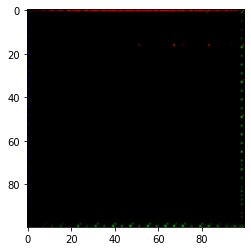

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


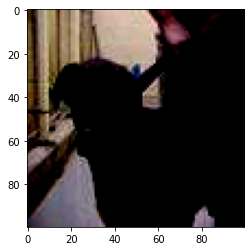

In [16]:
critic.batchSize = 1
critic.eval()
print(critic(dogdata[800][0].to(device).unsqueeze(0)))
rando = torch.randn([1, 100, 1, 1])
rando = rando.to(device)
print(critic(generator(rando)))

gen = generator(rando)
plt.imshow(gen[0].permute(1,2,0).cpu().detach().numpy())
plt.show()

plt.imshow(dogdata[0][0].permute(1,2,0))
plt.show()

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive
